In [44]:
import io
import pandas as pd

def parse_data(fpath):
    with open(fpath, 'r') as f:
        data = {}
        date = None

        for line in f.readlines():
            if line.startswith('#'):
                date = line.replace('#', '').strip()
                data[date] = []
            else:
                data[date].append(line)
                
    data = {k: ''.join(v) for k, v in data.items()}
    data = {k: pd.read_csv(io.BytesIO(str.encode(v)), sep='\t')
            for k, v in data.items()}
    for k, df in data.items():
        df['date'] = k
        
    df = pd.concat(data.values()).reset_index(drop=True)
    return df

df = pd.concat([parse_data('daily-leaders-202110.txt'), 
                parse_data('daily-leaders-202111.txt')]).reset_index(drop=True)

In [45]:
df.shape

(1170, 17)

In [46]:
df.head()

,RK,PLAYER,TEAM,OPP,SCORE,MIN,FGM-A,3PM-A,FTM-A,REB,AST,STL,BLK,TO,PTS,ESPN,date
0,1.0,G. Antetokounmpo,Mil,BKN,104-127 W,31,12-25,1-4,7-9,14,7,1,2,4,32,59.1,20211019
1,2.0,L. James,LAL,GS,121-114 L,37,13-23,5-11,3-6,11,5,1,1,4,34,57.5,20211019
2,3.0,K. Durant,BKN,@Mil,104-127 L,30,13-25,3-7,3-6,11,4,0,2,1,32,54.0,20211019
3,4.0,A. Davis,LAL,GS,121-114 L,39,15-26,1-5,2-7,11,2,1,2,0,33,53.8,20211019
4,5.0,J. Harden,BKN,@Mil,104-127 L,31,6-16,4-8,4-4,8,8,1,2,4,20,41.2,20211019


In [53]:
players = sorted(list(df['PLAYER'].unique()))
p2i = {p: i for i, p in enumerate(players)}
n_players = len(players)

n_players

225

In [54]:
dates = sorted(list(df['date'].unique()))

len(dates)

39

In [89]:
from itertools import combinations, chain
import numpy as np

def get_indices(date, field, ascending):
    p = df[df.date == date].sort_values([field], ascending=ascending)[['PLAYER', field]]
    p['index'] = p['PLAYER'].apply(lambda n: p2i[n])
    p = [(r['index'], r[field]) for _, r in p.iterrows()]
    p = combinations(p, 2)
    p = filter(lambda tup: tup[0][1] != tup[1][1], p)
    p = map(lambda tup: (tup[0][0], tup[1][0]), p)

    return p

def get_mat(field, ascending):
    indices = chain(*(get_indices(d, field, ascending) for d in dates))
    mat = np.zeros([n_players, n_players])

    for r, c in indices:
        mat[r, c] += 1

    mat = pd.DataFrame(mat, columns=players, index=players)
    
    return mat

In [90]:
mat_espn = get_mat('ESPN', False)
mat_pts = get_mat('PTS', False)

In [91]:
def get_estimate(i, p, df):
    get_prob = lambda i, j: np.nan if i == j else p.iloc[i] + p.iloc[j]
    n = df.iloc[i].sum()
    
    d_n = df.iloc[i] + df.iloc[:, i]
    d_d = pd.Series([get_prob(i, j) for j in range(len(p))], index=p.index)
    d = (d_n / d_d).sum()
    
    return n / d

def estimate_p(p, df):
    return pd.Series([get_estimate(i, p, df) for i in range(df.shape[0])], index=p.index)


def iterate(df, p=None, n=20, sorted=True):
    if p is None:
        p = pd.Series([1 for _ in range(df.shape[0])], index=list(df.columns))
        
    estimates = [p]
    
    for _ in range(n):
        p = estimate_p(p, df)
        p = p / p.sum()
        estimates.append(p)
    
    p = p.sort_values(ascending=False) if sorted else p
    return p, pd.DataFrame(estimates)

In [92]:
p_espn, estimates_espn = iterate(mat_espn, n=100)

In [93]:
p_pts, estimates_pts = iterate(mat_pts, n=100)

In [94]:
p_espn.head(n=10)

N. Alexander-Walker    0.044222
T. Craig               0.041073
N. Jokic               0.034626
J. McGee               0.023787
S. Dinwiddie           0.023776
D. Murray              0.020776
G. Antetokounmpo       0.020496
J. Butler              0.015916
P. Siakam              0.014495
P. George              0.013914
dtype: float64

In [95]:
p_pts.head(n=10)

T. Craig               0.047791
N. Alexander-Walker    0.030448
C. Sexton              0.029378
F. Wagner              0.022652
K. Middleton           0.020467
M. Beasley             0.019197
K. Oubre Jr.           0.019069
D. McDermott           0.018819
P. George              0.017132
R. Rubio               0.016942
dtype: float64

In [100]:
pd.DataFrame([p_espn.sort_index(), p_pts.sort_index()]).T.rename(columns={0: 'ESPN', 1: 'PTS'}).corr()

,ESPN,PTS
ESPN,1.000000,0.658554
PTS,0.658554,1.000000


<AxesSubplot:xlabel='ESPN', ylabel='PTS'>

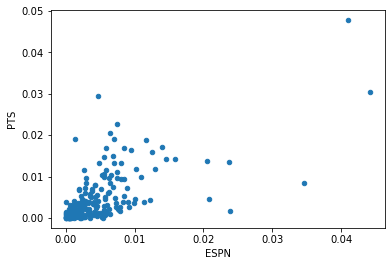

In [103]:
pd.DataFrame([p_espn.sort_index(), p_pts.sort_index()]).T.rename(columns={0: 'ESPN', 1: 'PTS'}).plot(kind='scatter', x='ESPN', y='PTS')